Search number of neighbors by AUC

In [ ]:
from pathlib import Path
import sys
import random
from concurrent.futures import ProcessPoolExecutor, wait

from Bio.SCOP import Scop
from Bio import SeqIO
import numpy as np

sys.path.append(Path().resolve().parent.as_posix())
from machina.predict import predict_by_flann


def process(n_neighbors):
    scop_root = Scop(dir_path='../data/train', version='1.75')
    scop40 = SeqIO.index('../data/train/astral-scopdom-seqres-gd-sel-gs-bib-40-1.75.fa', 'fasta')
    args = []
    for query in np.load('../data/hyperparam_validation_domain_ids.npy'):
        for domain in scop_root.getDomainBySid(query).getAscendent('sf').getDescendents('px'):
            if domain.sid in scop40:
                args.append((query, domain.sid))
    random.shuffle(args)
    predict_by_flann('../data/train/scop40_logscore_tmscore0.5_window5_ratio0.1_x.npy',
                     '../data/train/scop40_logscore_tmscore0.5_window5_ratio0.1_y.npy',
                     '../data/train/flann19_scop40_logscore_tmscore0.5_window5_ratio0.1',
                     n_neighbors,
                     f'../data/prediction/flann19_scop40_logscore_tmscore0.5_window5_ratio0.1_nn{n_neighbors}',
                     '../data/train/pssm',
                     args)

with ProcessPoolExecutor(max_workers=6) as executor:
    wait([executor.submit(process, 10) for _ in range(6)])
with ProcessPoolExecutor(max_workers=6) as executor:
    wait([executor.submit(process, 100) for _ in range(6)])
with ProcessPoolExecutor(max_workers=6) as executor:
    wait([executor.submit(process, 1000) for _ in range(6)])

,d3ctda1,d3e5ua2,d1xmba1,d2jmua1,d2zd1b1,d3cx5e2,d2vuti1
count,12.000000,15.000000,32.000000,4.000000,22.000000,3.000000,64.000000
mean,0.671848,0.813931,0.607767,0.577905,0.563720,0.658413,0.682096
std,0.103475,0.070257,0.058273,0.029357,0.027847,0.152972,0.064378
min,0.538960,0.718549,0.523048,0.552336,0.520638,0.530639,0.537079
25%,0.619365,0.753074,0.563906,0.555999,0.548612,0.573659,0.635900
50%,0.647361,0.800648,0.607675,0.571761,0.559389,0.616680,0.680737
75%,0.666200,0.883535,0.633281,0.593667,0.571287,0.722300,0.727007
max,0.887330,0.918483,0.818621,0.615764,0.626592,0.827921,0.829523


IndexError: too many indices for array

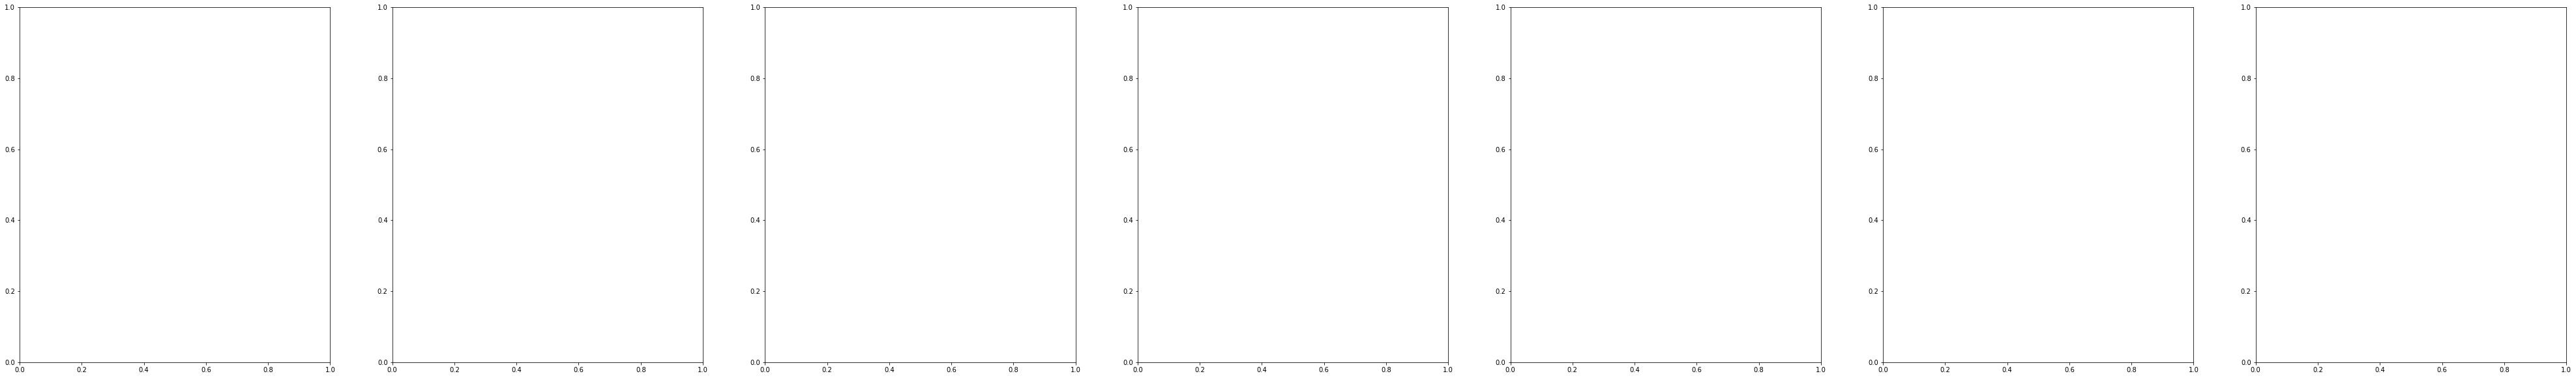

In [3]:
%matplotlib inline

from pathlib import Path
import sys

from tqdm import tqdm_notebook as tqdm
from Bio.SCOP import Scop
from Bio import SeqIO
import numpy as np
from sklearn import metrics
from matplotlib import pyplot
import seaborn
import pandas
from IPython.display import display

sys.path.append(Path().resolve().parent.as_posix())
from machina.generate_training_dataset import get_validation_label

scop_root = Scop(dir_path='../data/train', version='1.75')
test_domain = np.load('../data/hyperparam_validation_domain_ids.npy')
scop40 = SeqIO.index('../data/train/astral-scopdom-seqres-gd-sel-gs-bib-40-1.75.fa', 'fasta')
structural_alignments = SeqIO.index('../data/train/scop40_structural_alignment.fasta', 'fasta')

# Get ROC and calculate AUC
auc_d = {}
roc_d = {}
for query in tqdm(test_domain):
    auc_d[query] = []
    roc_d[query] = {}
    roc_d[query]['fpr'] = []
    roc_d[query]['tpr'] = []
    roc_d[query]['index'] = []
    i = 0
    for domain in [_.sid for _ in scop_root.getDomainBySid(query).getAscendent('sf').getDescendents('px')]:
        if domain not in scop40:
            continue
        if domain == query:
            continue
        test = get_validation_label(query, domain, structural_alignments, '../data/train/pssm').flatten()
        pred = np.load(f'../data/prediction/flann19_scop40_logscore_tmscore0.5_window5_ratio0.1_nn100/{query}/{domain}.npy').flatten()
        assert test.shape[0] == pred.shape[0]
        fpr, tpr, _ = metrics.roc_curve(test, pred)
        auc_d[query].append(metrics.auc(fpr, tpr))
        roc_d[query]['fpr'].extend(fpr)
        roc_d[query]['tpr'].extend(tpr)
        roc_d[query]['index'].extend([i]*len(fpr))
        i += 1

auc_df = pandas.DataFrame.from_dict(auc_d, orient='index')
auc_df = auc_df.transpose()
display(auc_df.describe())

# Visualize
fig, axes = pyplot.subplots(1, 7, figsize=(70, 10))
# seaborn.set_context('talk')
i = 0
for query in tqdm(test_domain):
    roc_df = pandas.DataFrame.from_dict(roc_d[query])
    seaborn.lineplot(x='fpr', y='tpr', data=roc_df, hue='index', linewidth=.6,
                     palette=seaborn.color_palette('Blues_d', len(auc_d[query])),
                     hue_order=sorted(range(len(auc_d[query])), key=lambda _: auc_d[query][_], reverse=True),
                     ax=axes[int(i/7), i%7], legend=False)
    avgauc = auc_df[query].mean()
    axes[int(i/7), i%7].set_title(f'{query} ({avgauc:.2f})')
    axes[int(i/7), i%7].set_xlabel('')
    axes[int(i/7), i%7].set_ylabel('')
    i += 1

Train, Validation, Test data Checker

In [1]:
from pathlib import Path
import pickle

import numpy as np
from Bio.SCOP import Scop

validation_data = np.load('data/test/scop40.npy')
scop_root = Scop(dir_path='data/scop', version='1.75')
with Path('data/train/scop40_hie.pkl').open('rb') as f:
    scop40_hie = pickle.load(f)
for k in scop40_hie:
    for d in scop40_hie[k]:
        assert d not in validation_data

KFold split

In [3]:
from pathlib import Path
import pickle
from concurrent.futures import ProcessPoolExecutor, wait
import random

from Bio.SCOP import Scop
from sklearn.model_selection import KFold
from IPython.display import display
import numpy as np

from machina.predict import predict_by_flann


validation_data = np.load('data/test/scop40.npy')
scop_root = Scop(dir_path='data/scop', version='1.75')
with Path('data/train/scop40_hie.pkl').open('rb') as f:
    scop40_hie = pickle.load(f)
scop40_hie_10 = [_ for _ in scop40_hie if len(scop40_hie[_]) > 10]
print(len(scop40_hie_10))
kfold = []
for _, test in list(KFold(n_splits=4, shuffle=True).split(scop40_hie_10)):
    kfold.append([random.choice(scop40_hie[scop40_hie_10[__]]) for __ in test])
# np.save(fname, np.array(kfold))

210


Prediction

In [ ]:
from pathlib import Path
from concurrent.futures import ProcessPoolExecutor, wait

from Bio.SCOP import Scop
from sklearn.model_selection import KFold
from IPython.display import display
import numpy as np

from machina.predict import predict_by_flann


validation_data = np.load('data/test/scop40.npy')
scop_root = Scop(dir_path='data/scop', version='1.75')
with Path('data/train/scop40_hie.pkl').open('rb') as f:
    scop40_hie = pickle.load(f)
kfolds = np.load(f'data/train/scop40_over10_4fold.npy')
model_name = 'flann19_scop40_logscore_tmscore50_w5_randomsampling_ratio0.1'
num_neighbors = 1000  # or 100
x = np.load(
    'data/train/scop40_logscore_tmscore50_w5_randomsampling_ratio0.1_x.npy')
y = np.load(
    'data/train/scop40_logscore_tmscore50_w5_randomsampling_ratio0.1_y.npy')


def process():
    for fold in kfolds:
        for query in fold:
            assert query not in validation_data
            args = [(query, _) for _ in scop40_hie[scop_root.getDomainBySid(
                query).getAscendent('sf').sunid]]
            random.shuffle(args)
            predict_by_flann(x, y, 200, model_name, num_neighbors, args)


workers = 4
with ProcessPoolExecutor(max_workers=workers) as executor:
    wait([executor.submit(process) for _ in range(workers)])

Alignment generation

In [ ]:
from pathlib import Path
import pickle
from concurrent.futures import ProcessPoolExecutor, as_completed
import random

from tqdm import tqdm
import numpy as np
from Bio.SCOP import Scop

from machina.generate_alignment import generate_alignment


with Path('data/train/scop40_hie.pkl').open('rb') as f:
    scop40_hie = pickle.load(f)
scop_root = Scop(dir_path='data/scop', version='1.75')
model_name = 'flann19_scop40_logscore_tmscore50_w5_randomsampling_ratio0.1_nn1000'  # or nn100
result_dir = Path('results')/model_name
GRID_GAP_OPEN = (-0.01, -0.05, -0.1, -0.5, -1.0)
GRID_GAP_EXTEND = (-0.001, -0.005, -0.01, -0.05, -0.1)


for GAP_OPEN in tqdm(GRID_GAP_OPEN):
    for GAP_EXTEND in tqdm(GRID_GAP_EXTEND):
        if GAP_OPEN > GAP_EXTEND:
            continue
        for fold in np.load('data/train/scop40_over10_4fold.npy'):
            random.shuffle(fold)
            for query in fold:
                result_file = result_dir / \
                    Path(f'{query}_open{-GAP_OPEN}_extend{-GAP_EXTEND}.npy')
                if result_file.exists():
                    continue
                with ProcessPoolExecutor() as executor:
                    futures = []
                    for template in scop40_hie[scop_root.getDomainBySid(query).getAscendent('sf').sunid]:
                        futures.append(executor.submit(
                            generate_alignment, Path(f'data/prediction/{model_name}/{query}/{template}.npy'), GAP_OPEN, GAP_EXTEND))
                    results = [_.result() for _ in as_completed(futures)]
                np.save(result_file, np.array(results))

In [ ]:
from pathlib import Path
import pickle
from concurrent.futures import ProcessPoolExecutor, wait
import random

from tqdm import tqdm
import numpy as np
from Bio.SCOP import Scop

from machina.generate_models import MachinaModel


with Path('data/train/scop40_hie.pkl').open('rb') as f:
    scop40_hie = pickle.load(f)
scop_root = Scop(dir_path='data/scop', version='1.75')
model_name = 'flann19_scop40_logscore_tmscore50_w5_randomsampling_ratio0.1_nn1000'  # or 100
result_dir = Path('results')/model_name
GRID_GAP_OPEN = (-0.01, -0.05, -0.1, -0.5, -1.0)
GRID_GAP_EXTEND = (-0.001, -0.005, -0.01, -0.05, -0.1)


def _process(args):
    for a in args:
        MachinaModel().generate_protein_model(a[0], a[1], a[2], a[3])


for GAP_OPEN in tqdm(GRID_GAP_OPEN):
    for GAP_EXTEND in tqdm(GRID_GAP_EXTEND):
        if GAP_OPEN > GAP_EXTEND:
            continue
        for fold in np.load('data/train/scop40_over10_4fold.npy'):
            random.shuffle(fold)
            with ProcessPoolExecutor() as executor:
                futures = []
                for query in fold:
                    aligns_list = np.load(
                        result_dir/Path(f'{query}_open{-GAP_OPEN}_extend{-GAP_EXTEND}.npy'))
                    out_dir = f'results/{model_name}/open{-GAP_OPEN}extend{-GAP_EXTEND}/{query}'
                    l = [(query, template, aligns_list, out_dir) for template in scop40_hie[scop_root.getDomainBySid(query).getAscendent('sf').sunid]
                    futures.append(executor.submit(generate_alignment, l)
                wait(futures)

In [ ]:
from pathlib import Path
import pickle
from concurrent.futures import ThreadPoolExecutor, as_completed

from Bio.SCOP import Scop
import numpy as np
from tqdm import tqdm
import pandas

from machina.TMtoolsCommandLine import TMalignCommandLine


scop_root = Scop(dir_path=Path('data/scop'), version='1.75')
with Path('data/train/scop40_hie.pkl').open('rb') as f:
    scop40_hie = pickle.load(f)
test_data = np.load('data/test/scop40.npy')
model_name = 'flann19_scop40_logscore_tmscore50_w5_randomsampling_ratio0.1_nn1000'  # or 100
GRID_GAP_OPEN = (-0.01, -0.05, -0.1, -0.5, -1.0)
GRID_GAP_EXTEND = (-0.001, -0.005, -0.01, -0.05, -0.1)


def _process(pdb_file, query_sid):
    tmalign = TMalignCommandLine(pdb_file, f'data/scop_e/{query_sid[2:4]}/{query_sid}.ent')
    tmalign.run()
    if tmalign.tmscore is None:
        return None
    else:
        return tmalign.tmscore[1]


nfold = 1
for fold in tqdm(np.load('data/train/scop40_over10_4fold.npy')):
    result_d = {}
    for GAP_OPEN in GRID_GAP_OPEN:
        for GAP_EXTEND in GRID_GAP_EXTEND:
            if GAP_EXTEND < GAP_OPEN:
                continue
            with ThreadPoolExecutor() as executor:
                futures = []
                for query in fold:
                    pdb_list = [f'results/{model_name}/open{-GAP_OPEN}extend{-GAP_EXTEND}/{query}/{_}.pdb'
                                for _ in scop40_hie[scop_root.getDomainBySid(query).getAscendent('sf').sunid] if _ != query]
                    futures.extend([executor.submit(_process, _, query) for _ in pdb_list])
                result_d[f'{-GAP_OPEN}\n{-GAP_EXTEND}'] = [_.result() for _ in as_completed(futures)]
    pandas.DataFrame.from_dict(result_d, orient='index').transpose().to_csv(f'result_fold{nfold}_{model_name}.csv')
    nfold += 1

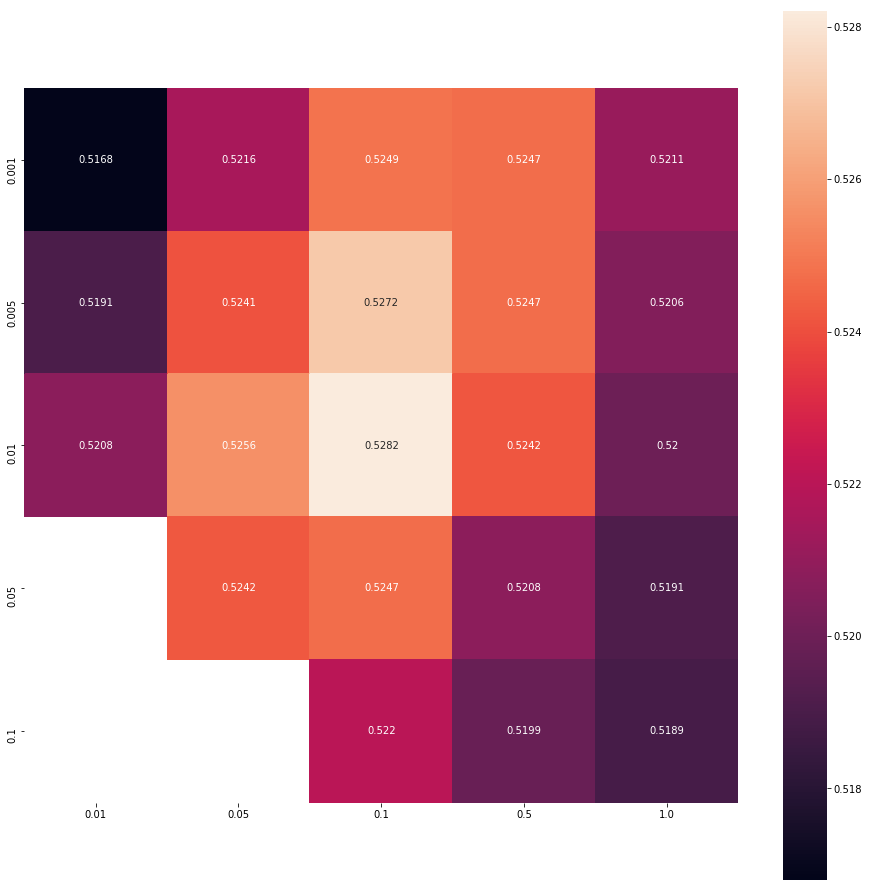

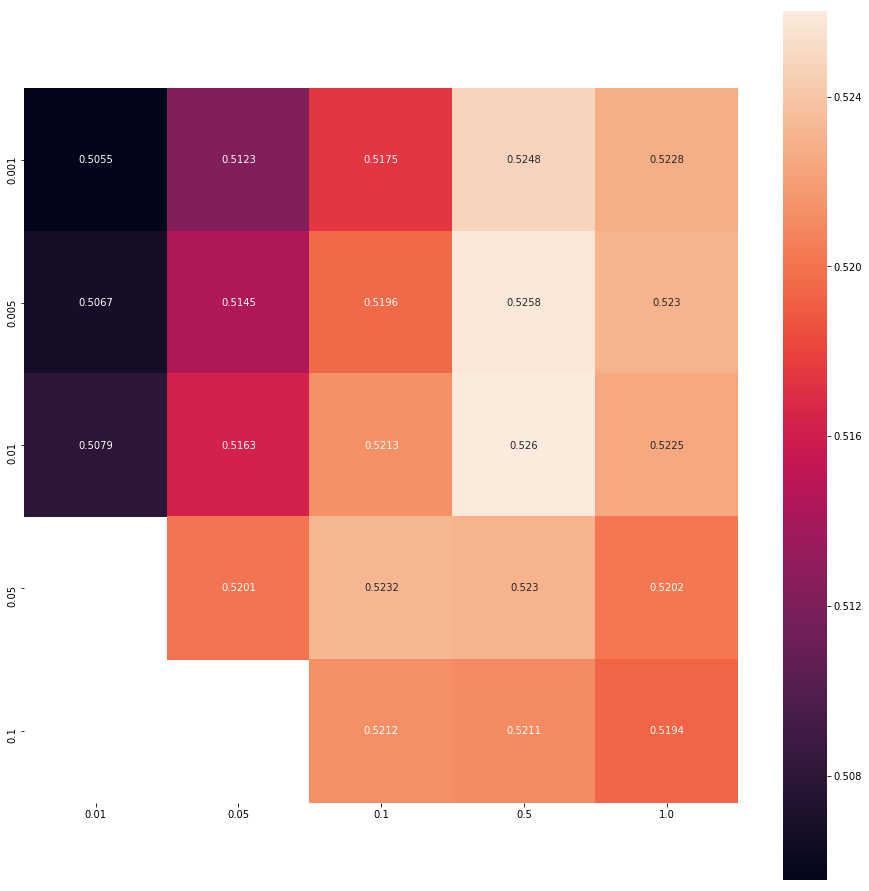

In [22]:
%matplotlib inline

import pandas
from matplotlib import pyplot
import seaborn as sns
import numpy as np

GRID_GAP_OPEN = (-0.01, -0.05, -0.1, -0.5, -1.0)
GRID_GAP_EXTEND = (-0.001, -0.005, -0.01, -0.05, -0.1)

model_name = 'flann19_scop40_logscore_tmscore50_w5_randomsampling_ratio0.1_nn1000'  # or 100

grid_d = {}
for GAP_OPEN in GRID_GAP_OPEN:
    grid_d[f'{-GAP_OPEN}'] = {}
    for GAP_EXTEND in GRID_GAP_EXTEND:
        if GAP_EXTEND < GAP_OPEN:
            continue
        mean = [pandas.read_csv(f'result_fold{i+1}_{model_name}.csv')[f'{-GAP_OPEN}\n{-GAP_EXTEND}'].mean() for i in range(4)]
        grid_d[f'{-GAP_OPEN}'][f'{-GAP_EXTEND}'] = np.array(mean).mean()
grid_df = pandas.DataFrame.from_dict(grid_d)
fig, ax = pyplot.subplots(figsize=(16, 16))
sns.heatmap(grid_df, ax=ax, linewidths=0, square=True, annot=True, fmt='.4g')

model_name = 'flann19_scop40_logscore_tmscore50_w5_randomsampling_ratio0.1_nn100'  # or 100

grid_d = {}
for GAP_OPEN in GRID_GAP_OPEN:
    grid_d[f'{-GAP_OPEN}'] = {}
    for GAP_EXTEND in GRID_GAP_EXTEND:
        if GAP_EXTEND < GAP_OPEN:
            continue
        mean = [pandas.read_csv(f'result_fold{i+1}_{model_name}.csv')[f'{-GAP_OPEN}\n{-GAP_EXTEND}'].mean() for i in range(4)]
        grid_d[f'{-GAP_OPEN}'][f'{-GAP_EXTEND}'] = np.array(mean).mean()
grid_df = pandas.DataFrame.from_dict(grid_d)
fig, ax = pyplot.subplots(figsize=(16, 16))
sns.heatmap(grid_df, ax=ax, linewidths=0, square=True, annot=True, fmt='.4g')